# SSD

*Author: NVIDIA*

**Single Shot MultiBox Detector model for object detection**

_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)

PyTorch has a model repository called the PyTorch Hub, which is a source for high quality implementations of common models. We can get our SSD model from there pretrained on COCO

### Model Description

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as “a method for detecting objects in images using a single deep neural network".
The input size is fixed to 300x300.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
*   All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last conv4_x layer.
*   The other five detection heads are attached to the corresponding 5 additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

In [1]:
import torch

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math="fp32")
model = model.eval().to("cuda")

Using cache found in /home/narens/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [2]:
%%bash
pip install numpy scipy scikit-image matplotlib

To compile with TRTorch the model must first be in TorchScript. TorchScript is a programming language included in PyTorch which removes the Python dependency normal PyTorch models have. This conversion is done via a JIT compiler which given a PyTorch Module will generate an equivalent TorchScript Module. There are two paths that can be used to generate TorchScript: tracing and scripting. Tracing follows execution of PyTorch generating ops in TorchScript corresponding to what it sees. Scripting does an analysis of the Python code and generates TorchScript, this allows the resulting graph to include control flow which tracing cannot do. Tracing however due to its simplicity is more likely to compile successfully with TRTorch (though both systems are supported).

In [3]:
ts_model = torch.jit.trace(model, [torch.randn((1,3,300,300)).to("cuda")])

We can save this model and use it independently of Python.

In [11]:
torch.jit.save(ts_model, "ssd_300_traced.jit.pt")

TorchScript modules behave just like normal PyTorch modules and are intercompatable. From TorchScript we can now compile a TensorRT based module. This module will still be implemented in TorchScript but all the computation will be done in TensorRT

In [23]:
import trtorch

trt_model = trtorch.compile(ts_model, {
    "input_shapes": [(3, 3, 300, 300)],
    "op_precision": torch.half,
    "workspace_size": 1 << 20
})

In [24]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

In [25]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, False)
classes_to_labels = utils.get_coco_object_dictionary()

Using cache found in /home/narens/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [26]:
detections_batch = trt_model(tensor.to(torch.half))

In [27]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

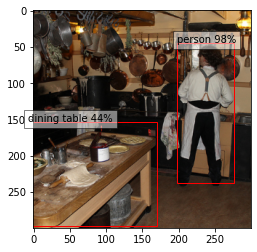

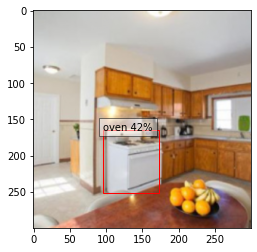

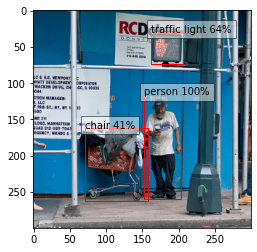

In [28]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

### Details
For detailed information on model input and output,
training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
and/or [NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)

### References

 - [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper
 - [Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012) paper
 - [SSD on NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)
 - [SSD on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)